In [ ]:
import sys
from pathlib import Path
parent_dir = Path().resolve().parent
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))

from pathlib import Path
import numpy as np 
import pandas as pd 
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MultiLabelBinarizer

import torch
import torch.nn as nn
import torch.nn.functional as F

# Load data

In [ ]:
TOP_K_LABELS = 500

# Load protein-term data
train_term_df = pd.read_csv(
    "../data/Train/train_terms.tsv", 
    sep="\t")
protein_to_terms = train_term_df.groupby('EntryID')['term'].apply(list)
print(len(protein_to_terms))

# Setup Label
term_count = train_term_df["term"].value_counts()
top_terms = term_count.index[:TOP_K_LABELS].tolist()
top_term_set = set(top_terms)
term2idx = {term: idx for idx, term in enumerate(top_terms)}

protein_to_terms = protein_to_terms.apply(
    lambda terms: [t for t in terms if t in top_term_set]
)
protein_to_terms = protein_to_terms[protein_to_terms.apply(len) > 0]

print(protein_to_terms.head(10))
print(f"Protein: {len(protein_to_terms)}, Term: {len(top_terms)}")

82404
EntryID
A0A023PXP4                [GO:0006974]
A0A023PZB3                [GO:0005739]
A0A024RBG1    [GO:0005515, GO:0005829]
A0A044RE18                [GO:0004252]
A0A059TC02    [GO:0005737, GO:0007623]
A0A060A682                [GO:0005911]
A0A060D764    [GO:0045893, GO:0005515]
A0A060KY90    [GO:0043565, GO:0045893]
A0A060X6Z0                [GO:0043204]
A0A061ACU2    [GO:0005886, GO:0030317]
Name: term, dtype: object
Protein: 72457, Term: 500


In [ ]:
ESM2_PATH = '../data/embedding/esm'

# Load embedding
train_ids = protein_to_terms.index
test_ids = np.load(f"{ESM2_PATH}/test_ids.npy", allow_pickle=True)
test_embeds = np.load(f"{ESM2_PATH}/test_embeddings.npy")

# Map dict
test_dict = {id: emb for id, emb in zip(test_ids, test_embeds)}
train_dict = test_dict

print("Train shape:", test_embeds.shape)
print("Test shape:", test_embeds.shape)

Train shape: (142246, 1280)
Test shape: (141864, 1280)


Valid protein size: 70214


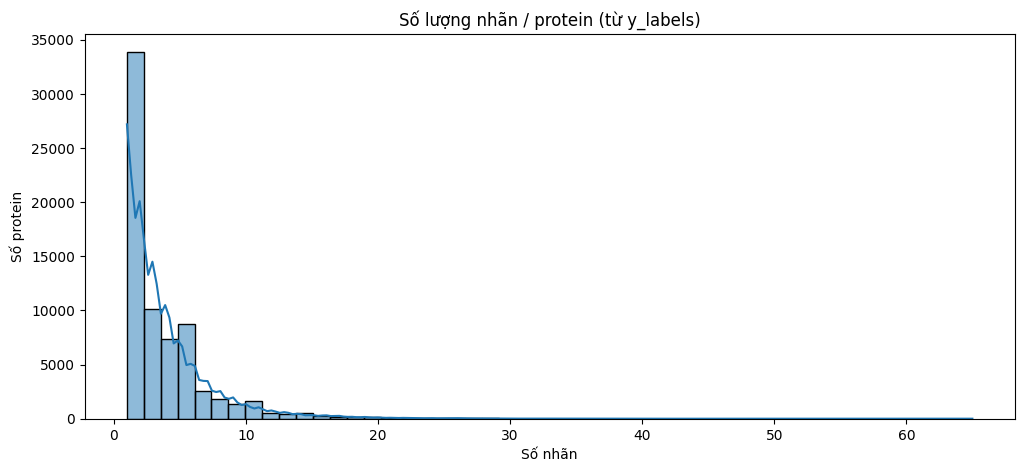

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import gc

protein_to_terms = protein_to_terms[protein_to_terms.index.isin(train_ids)]
print("Valid protein size:", len(protein_to_terms))

# Label mapping (size=750)
mlb = MultiLabelBinarizer(classes=range(len(top_terms)))
y_labels = [[term2idx[t] for t in terms] for terms in protein_to_terms]
y_encoded = mlb.fit_transform(y_labels)

label_counts = [len(lbls) for lbls in y_labels]

plt.figure(figsize=(12,5))
sns.histplot(label_counts, bins=50, kde=True)
plt.title("Số lượng nhãn / protein (từ y_labels)")
plt.xlabel("Số nhãn")
plt.ylabel("Số protein")
plt.show()

In [6]:
y_encoded = mlb.fit_transform(y_labels)

# Smoothing label
LABEL_SMOOTHING = 0.05
if LABEL_SMOOTHING > 0:
    y_encoded = y_encoded.astype(float) * (1-LABEL_SMOOTHING) + LABEL_SMOOTHING / len(top_terms)

valid_proteins = protein_to_terms.index.tolist()
# Split dataset
train_proteins, val_proteins, y_train, y_val = train_test_split(
    valid_proteins, y_encoded, test_size=0.15
)
print(f"Train: {len(train_proteins)}, Val: {len(val_proteins)}")

Train: 59681, Val: 10533


# Model

In [7]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims, dropout):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, dim),
                nn.BatchNorm1d(dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            prev_dim = dim

        self.encoder = nn.Sequential(*layers)
        self.output = nn.Linear(prev_dim, output_dim)

    def forward(self, x):
        return torch.sigmoid(self.output(self.encoder(x)))

In [ ]:
HIDDEN_DIMS = [512, 256, 128]
DROPOUT_RATE = 0.3         
EPOCHS = 30
BATCH_SIZE = 128               
LEARNING_RATE = 4e-3

input_dim = test_embeds.shape[1]
output_dim = len(top_terms)

# Init model
model = MLP(input_dim, output_dim, HIDDEN_DIMS, DROPOUT_RATE)
metric = nn.BCELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, verbose=False)

In [ ]:
# Training
from tqdm import tqdm

best_val_loss = float('inf')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(EPOCHS):
    model.train()
    indices = np.random.permutation(len(train_proteins))
    epoch_loss = 0
    n_batches = 0

    # Training phase
    for i in range(0, len(indices), BATCH_SIZE):
        batch_idx = indices[i: i+BATCH_SIZE]
        batch_proteins = [train_proteins[j] for j in batch_idx]

        X_batch = torch.FloatTensor([train_dict[p] for p in batch_proteins]).to(device)
        y_batch = torch.FloatTensor(y_train[batch_idx]).to(device)

        optimizer.zero_grad()
        output = model(X_batch)
        loss = metric(output, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        epoch_loss += loss.item()
        n_batches += 1

    # Evaluation phase
    model.eval()
    val_loss, val_batches = 0, 0

    with torch.no_grad():
        for i in range(0, len(val_proteins), BATCH_SIZE):
            batch_proteins = val_proteins[i: i+BATCH_SIZE]
    
            X_batch = torch.FloatTensor([train_dict[p] for p in batch_proteins]).to(device)
            y_batch = torch.FloatTensor(y_val[i: i+BATCH_SIZE]).to(device)
    
            output = model(X_batch)
            loss = metric(output, y_batch)
            val_loss += loss.item()
            val_batches += 1
    
    train_loss_avg = epoch_loss/n_batches
    val_loss_avg = val_loss/val_batches
    
    scheduler.step(val_loss_avg)

    if val_loss_avg < best_val_loss:
        best_val_loss = val_loss_avg
        print(f"Epoch {epoch+1}: Train_Loss={train_loss_avg:.4f}, Val_Loss={val_loss_avg:.4f} => NEW BEST")
    else:
        print(f"Epoch {epoch+1}: Train_Loss={train_loss_avg:.4f}, Val_Loss={val_loss_avg:.4f}")


print(f"\n✅ Best Validation Loss: {best_val_loss:.4f}")

Epoch 1: Train_Loss=0.0416, Val_Loss=0.0296 => NEW BEST
Epoch 2: Train_Loss=0.0301, Val_Loss=0.0290 => NEW BEST
Epoch 3: Train_Loss=0.0298, Val_Loss=0.0288 => NEW BEST
Epoch 4: Train_Loss=0.0298, Val_Loss=0.0288 => NEW BEST
Epoch 5: Train_Loss=0.0298, Val_Loss=0.0290
Epoch 6: Train_Loss=0.0297, Val_Loss=0.0290
Epoch 7: Train_Loss=0.0299, Val_Loss=0.0289
Epoch 8: Train_Loss=0.0292, Val_Loss=0.0283 => NEW BEST
Epoch 9: Train_Loss=0.0291, Val_Loss=0.0281 => NEW BEST
Epoch 10: Train_Loss=0.0291, Val_Loss=0.0280 => NEW BEST
Epoch 11: Train_Loss=0.0290, Val_Loss=0.0280
Epoch 12: Train_Loss=0.0290, Val_Loss=0.0280
Epoch 13: Train_Loss=0.0289, Val_Loss=0.0279 => NEW BEST
Epoch 14: Train_Loss=0.0289, Val_Loss=0.0280
Epoch 15: Train_Loss=0.0289, Val_Loss=0.0279
Epoch 16: Train_Loss=0.0289, Val_Loss=0.0278 => NEW BEST
Epoch 17: Train_Loss=0.0289, Val_Loss=0.0280
Epoch 18: Train_Loss=0.0288, Val_Loss=0.0278 => NEW BEST
Epoch 19: Train_Loss=0.0288, Val_Loss=0.0279
Epoch 20: Train_Loss=0.0288, Val_L

# Predict and Submission

In [10]:
model.eval()
test_protein_ids = list(test_dict.keys())
PREDICT_BATCH_SIZE = 128
TEMPERATURE = 1.5
MAX_PREDS_PER_PROTEIN = 200
MIN_CONFIDENCE = 0.08

n_predictions = 0
with open('temp_dl.tsv', 'w', newline='') as f:
    with torch.no_grad():
        for start in tqdm(range(0, len(test_protein_ids), PREDICT_BATCH_SIZE), desc="Predicting"):
            batch_ids = test_protein_ids[start:start + PREDICT_BATCH_SIZE]
            X_batch = torch.FloatTensor([test_dict[p] for p in batch_ids]).to(device)
            
            # Get raw logits before sigmoid
            logits = model.encoder(X_batch)
            logits = model.output(logits)
            
            # Apply temperature scaling
            outputs = torch.sigmoid(logits / TEMPERATURE).cpu().numpy()
            
            for i, pid in enumerate(batch_ids):
                probs = outputs[i]
                top_indices = np.argsort(probs)[::-1][:MAX_PREDS_PER_PROTEIN]
                confident_indices = [idx for idx in top_indices if probs[idx] > MIN_CONFIDENCE]
                
                for idx in confident_indices:
                    line = f"{pid}\t{top_terms[idx]}\t{min(probs[idx], 0.999):.3f}\n"
                    f.write(line)
                    n_predictions += 1
            
            del X_batch, outputs, logits
            if start % 1000 == 0:
                gc.collect()

print(f"✓ Generated {n_predictions:,} predictions")

Predicting: 100%|██████████| 1109/1109 [01:31<00:00, 12.12it/s]

✓ Generated 2,475,658 predictions


In [ ]:
!head -n 10 temp_dl.tsv

Q9ZSA8	GO:0005515	0.251
Q9ZSA8	GO:0005634	0.241
Q9ZSA8	GO:0005829	0.229
Q9ZSA8	GO:0005737	0.163
Q9ZSA8	GO:0005739	0.109
Q9ZSA8	GO:0042803	0.101
Q9ZSA8	GO:0005886	0.100
Q9ZSA8	GO:0009414	0.100
Q9ZSA8	GO:0009753	0.099
Q9ZSA8	GO:0005783	0.092


In [ ]:
import csv
import os

DL_WEIGHT = 0.4
OLD_SUB_WEIGHT = 0.6
OLD_SUB_PATH = "/kaggle/input/sprott5-embedding-mlp-v1-submission/submission.tsv"

if os.path.exists('temp_dl.tsv') and os.path.exists(OLD_SUB_PATH):
    print("Ensembling DL predictions with previous submission...")

    # 1) Đọc DL result (temp_dl.tsv) và scale
    dl_df = pd.read_csv('temp_dl.tsv', sep='\t', header=None,
                        names=['Id', 'GO term', 'Confidence'])
    dl_df['Confidence'] = dl_df['Confidence'].astype(float) * DL_WEIGHT

    # 2) Đọc submission cũ và scale
    old_df = pd.read_csv(OLD_SUB_PATH, sep='\t', header=None,
                         names=['Id', 'GO term', 'Confidence'])
    old_df['Confidence'] = old_df['Confidence'].astype(float) * OLD_SUB_WEIGHT

    print(f"  DL rows = {len(dl_df):,}, OLD_SUB rows = {len(old_df):,}")

    # 3) Gộp 2 nguồn
    ensemble_df = pd.concat([dl_df, old_df], ignore_index=True)
    del dl_df, old_df
    gc.collect()

    # 4) Cộng confidence theo (Id, GO term)
    ensemble_df = (
        ensemble_df
        .groupby(['Id', 'GO term'], as_index=False)['Confidence']
        .sum()
    )

    # 5) Sort và lấy top 1500 GO term / protein
    ensemble_df = ensemble_df.sort_values(['Id', 'Confidence'],
                                          ascending=[True, False])
    ensemble_df = ensemble_df.groupby('Id').head(1500)

    # 6) Ghi ra submission.tsv giống format cũ
    ensemble_df.to_csv(
        'submission.tsv',
        sep='\t',
        header=False,
        index=False,
        quoting=csv.QUOTE_NONE,
        escapechar='\\',
        lineterminator='\n'
    )
    print(f"✓ Saved {len(ensemble_df):,} predictions")


else:
    # Nếu không có file cũ thì fallback: dùng đúng DL output
    print("Previous submission not found, using only DL predictions.")
    if os.path.exists('temp_dl.tsv'):
        os.rename('temp_dl.tsv', 'submission.tsv')
    else:
        raise FileNotFoundError("temp_dl.tsv not found!")

Ensembling DL predictions with previous submission...
  DL rows = 2,475,658, OLD_SUB rows = 16,985,535
✓ Saved 17,244,661 predictions


In [13]:
import csv

ensemble_df.to_csv(
    'submission.tsv',
    sep='\t',
    header=False,
    index=False,
    quoting=csv.QUOTE_NONE,
    escapechar='\\',
    lineterminator='\n'
)
print(f"✓ Saved {len(ensemble_df):,} predictions")

NameError: name 'ensemble_df' is not defined